**Qiskit Density Matrix**

In [34]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import DensityMatrix, Kraus
from qiskit_aer import AerSimulator
import numpy as np

T1 = 10 ** -4
n_qubits = 1
exact_params = []
np_taus = [10**-6, 10**-5, 5*10**-5, 10**-4]#, 1.5 * 10**-4]  # np.linspace(10**-6, 10**-4, num=10)
taus = [round(float(tau), 8) for tau in np_taus]
print(taus)
T2 = np.arange(T1/5, 2*T1 + T1/10, T1/10)
for tau in taus:  
    exact_rho = []
    for T in T2:
        lam = 1/T - 1/(2*T1)
        p_amp = 1-np.exp(-tau/T1)
        p_phase = 1-np.exp(-lam*tau)

        #Kraus

        #Amplitude damping (T1)
        K1_amp = np.array([[1, 0], [0, np.sqrt(1 - p_amp)]])
        K2_amp = np.array([[0, np.sqrt(p_amp)], [0, 0]])
        amp_damping = Kraus([K1_amp, K2_amp])

        #Phase damping (T2)
        # K1_phase = np.array([[np.sqrt(1 - p_phase), 0], [0, -np.sqrt(1 - p_phase)]])
        # K2_phase = np.array([[np.sqrt(p_phase), 0], [0, np.sqrt(p_phase)]])

        #N&C
        # K1_phase = np.array([[1, 0], [0, np.sqrt(1 - p_phase)]])
        # K2_phase = np.array([[0, 0], [0, np.sqrt(p_phase)]])
        # phase_damping = Kraus([K1_phase, K2_phase])

        #Preskill
        K1_phase = np.array([[np.sqrt(1 - p_phase), 0], [0, np.sqrt(1 - p_phase)]])
        K2_phase = np.array([[np.sqrt(p_phase), 0], [0, 0]])
        K3_phase = np.array([[0, 0], [0, np.sqrt(p_phase)]])
        phase_damping = Kraus([K1_phase, K2_phase, K3_phase])

        # #Combined operators
        # K1_comb = np.array([[1, 0], [0, np.sqrt(1 - p_amp) * np.sqrt(1 - p_phase)]])
        # K2_comb = np.array([[0, np.sqrt(p_amp)], [0, 0]])
        # K3_comb = np.array([[0, 0], [0, np.sqrt(1 - p_amp) * np.sqrt(p_phase)]])
        # comb_damping = Kraus([K1_comb, K2_comb, K3_comb])


        #Circuit

        qc = QuantumCircuit(n_qubits)

        #GHZ
        qc.h(0)

        for q in range(n_qubits-1):
            qc.cx(q, q+1)

        #Add decoherence
        for qubit in range(n_qubits):
            qc.append(amp_damping.to_instruction(), [qubit])
            qc.append(phase_damping.to_instruction(), [qubit])
            # qc.append(comb_damping.to_instruction(), [qubit])

        qc.save_density_matrix()

        sim = AerSimulator(method='density_matrix')

        result = sim.run(qc).result()

        rho = np.array(result.data(0)['density_matrix'])
        # print("Final density matrix with manual gamma lambda noise:\n", DensityMatrix(rho))
        exact_rho.append(rho)

    exact_params.append(exact_rho)

print(rho)


[1e-06, 1e-05, 5e-05, 0.0001]
[[0.81606028+0.j 0.30326533+0.j]
 [0.30326533+0.j 0.18393972+0.j]]


**Statevector**

In [35]:
'''
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Kraus, DensityMatrix
import numpy as np

# Parameters
T1 = 10 ** -5
n_qubits = 1
num_shots = 1000  # Number of noisy samples
statevector_params = []

np_taus = np.linspace(10**-6, 10**-5, num=10)
taus = [round(float(tau), 16) for tau in np_taus]
T2 = np.arange(T1/10, 2*T1, T1/10)

# Simulate each tau
for tau in taus:  
    exact_rho = []
    for T in T2:
        lam = 1/T - 1/(2*T1)
        p_amp = 1 - np.exp(-tau/T1)
        p_phase = 1 - np.exp(-2*lam*tau)

        # Define Kraus operators
        # Amplitude damping
        K1_amp = np.array([[1, 0], [0, np.sqrt(1 - p_amp)]])
        K2_amp = np.array([[0, np.sqrt(p_amp)], [0, 0]])
        amp_damping = [K1_amp, K2_amp]

        # Phase damping
        K1_phase = np.array([[np.sqrt(1 - p_phase), 0], [0, np.sqrt(1 - p_phase)]])
        K2_phase = np.array([[np.sqrt(p_phase), 0], [0, -np.sqrt(p_phase)]])
        phase_damping = [K1_phase, K2_phase]

        # Base state preparation
        qc = QuantumCircuit(n_qubits)
        qc.h(0)  # You can add more gates here (e.g., entangling)
        psi = Statevector(qc)

        # Noisy sampling
        noisy_density = np.zeros((2, 2), dtype=complex)

        for _ in range(num_shots):
            # Start from same state
            noisy_psi = psi

            # Sample amplitude damping Kraus
            probs = [
                np.linalg.norm(amp_damping[0] @ noisy_psi.data) ** 2,
                np.linalg.norm(amp_damping[1] @ noisy_psi.data) ** 2
            ]
            probs = np.array(probs)
            probs /= np.sum(probs)
            k_amp = amp_damping[np.random.choice([0, 1], p=probs)]


            # Sample phase damping Kraus
            # Compute and normalize probabilities
            probs = [
                np.linalg.norm(phase_damping[0] @ noisy_psi.data) ** 2,
                np.linalg.norm(phase_damping[1] @ noisy_psi.data) ** 2
            ]
            probs = np.array(probs)
            probs /= np.sum(probs)  # normalize to sum to 1

            # Sample Kraus operator
            k_phase = phase_damping[np.random.choice([0, 1], p=probs)]


            # Accumulate outer product
            noisy_density += np.outer(noisy_psi.data, np.conj(noisy_psi.data))

        # Normalize to form approximate density matrix
        noisy_density /= num_shots
        exact_rho.append(noisy_density)

    statevector_params.append(exact_rho)

print(T2)
'''

'\nfrom qiskit import QuantumCircuit\nfrom qiskit.quantum_info import Statevector, Kraus, DensityMatrix\nimport numpy as np\n\n# Parameters\nT1 = 10 ** -5\nn_qubits = 1\nnum_shots = 1000  # Number of noisy samples\nstatevector_params = []\n\nnp_taus = np.linspace(10**-6, 10**-5, num=10)\ntaus = [round(float(tau), 16) for tau in np_taus]\nT2 = np.arange(T1/10, 2*T1, T1/10)\n\n# Simulate each tau\nfor tau in taus:  \n    exact_rho = []\n    for T in T2:\n        lam = 1/T - 1/(2*T1)\n        p_amp = 1 - np.exp(-tau/T1)\n        p_phase = 1 - np.exp(-2*lam*tau)\n\n        # Define Kraus operators\n        # Amplitude damping\n        K1_amp = np.array([[1, 0], [0, np.sqrt(1 - p_amp)]])\n        K2_amp = np.array([[0, np.sqrt(p_amp)], [0, 0]])\n        amp_damping = [K1_amp, K2_amp]\n\n        # Phase damping\n        K1_phase = np.array([[np.sqrt(1 - p_phase), 0], [0, np.sqrt(1 - p_phase)]])\n        K2_phase = np.array([[np.sqrt(p_phase), 0], [0, -np.sqrt(p_phase)]])\n        phase_dampi

**Stim + Pauli Twirling**

In [36]:
import stim
import numpy as np

# Define Pauli matrices
I = np.array([[1, 0], [0, 1]], dtype=complex)
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)
pauli_map = {'_': I, 'X': X, 'Y': Y, 'Z': Z}

def kronecker_all(pauli_string):
    """Kronecker product over all characters in pauli_string."""
    result = np.array([[1]], dtype=complex)
    for p in pauli_string:
        result = np.kron(result, pauli_map[p])
    return result

def tableau_to_density_matrix(t: stim.Tableau) -> np.ndarray:
    """Convert a stim.Tableau to a density matrix using canonical stabilizers."""
    s = stim.TableauSimulator()
    s.set_inverse_tableau(t)
    stabilizers = s.canonical_stabilizers()
    
    n = n_qubits
    dim = 1 << n
    rho = np.eye(dim, dtype=complex)
    # print(stabilizers)
    for stab in stabilizers:
        stab = str(stab)
        sign = -1 if stab[0] == '-' else 1
        pauli_string = stab[1:]  # e.g., "-XZ" -> "XZ"
        S = kronecker_all(pauli_string)
        S *= sign

        proj = 0.5 * (np.eye(dim, dtype=complex) + S)
        rho = rho @ proj

    return rho


def generate_error_circuit(p_amp: float, p_phase: float, circuit) -> stim.Circuit:
    """Apply twirled noise"""
    new_circuit = circuit.copy()
    for q in range(n_qubits):
        new_circuit.append("PAULI_CHANNEL_1", [q], [p_amp/4, p_amp/4,   ((1-np.sqrt((1-p_amp)*(1-p_phase)))/2)-p_amp/4])
        # new_circuit.append("PAULI_CHANNEL_1", [q], [0, 0,])

    return new_circuit


# Parameters
num_shots = 10000   # number of random shots

#Generate tableaus and density matrices

circuit = stim.Circuit("H 0")

for q in range(n_qubits-1):
    circuit.append("CX", [q, q+1])
stim_params = []
for tau in taus:  
    twirled = []
    for T in T2:
        stim_dms = []
        lam = 1/T - 1/(2*T1)
        p_amp = 1 - np.exp(-tau/T1)
        p_phase = 1 - np.exp(-lam*tau)
        temp_circuit = generate_error_circuit(p_amp, p_phase, circuit)
        for shot in range(num_shots):
            sim = stim.TableauSimulator()
            sim.do_circuit(temp_circuit)
            rho = tableau_to_density_matrix(sim.current_inverse_tableau())
            stim_dms.append(rho)
        avg_stim = sum(stim_dms)/ num_shots
        twirled.append(avg_stim)
    stim_params.append(twirled)

**STAB Sim Decomposition**


In [37]:
import subprocess
import numpy as np

stab_params = []

# Compile the C++ program
compile_result = subprocess.run(
        ["g++", "-std=c++20", "damping_channel.cpp", "-o", "damping_channel"],
        capture_output=True, text=True
    )
if compile_result.returncode != 0:
        print("Compilation failed:")
        print(compile_result.stderr)

for tau in taus:
    density_matrices = []
    for T in T2:
        lines = []
        rhos = []
        with subprocess.Popen(
            ["./damping_channel", str(n_qubits), str(tau), str(T1), str(T), str(num_shots)],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            bufsize=1
        ) as proc:
            for line in proc.stdout:
                # print(line, end="")  
                lines.append(line.strip())

            # Wait for process to finish
            proc.wait()

            if proc.returncode != 0:
                error_output = proc.stderr.read()
                print("Runtime Error:")
                print(error_output)
        i = 0
        while i < len(lines):
            if lines[i].startswith("T2="):
                T = float(lines[i].split("=")[1])
                i += 1
                data = list(map(float, lines[i].strip().split()))
                complex_vals = [complex(data[j], data[j+1]) for j in range(0, len(data), 2)]
                dim = int(len(complex_vals)**0.5)
                rho = np.array(complex_vals).reshape((dim, dim))
                rhos.append(rho)
            # elif lines[i].startswith("Time="):
            #     stab_time += float(lines[i].split("=")[1])
            i += 1
                    
        density_matrices.extend(rhos)
    stab_params.append(density_matrices)

**STABSim T1 T2 Quasiprobability**

In [38]:
import subprocess
import numpy as np

quasi_params = []

# Compile the C++ program
compile_result = subprocess.run(
        ["g++", "-std=c++20", "quasiprobability_channel.cpp", "-o", "quasiprobability_channel"],
        capture_output=True, text=True
    )
if compile_result.returncode != 0:
        print("Compilation failed:")
        print(compile_result.stderr)

stab_time = 0
for tau in taus:
    density_matrices = []
    for T in T2:
        lines = []
        rhos = []
        with subprocess.Popen(
            ["./quasiprobability_channel", str(n_qubits), str(tau), str(T1), str(T), str(1000)],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            bufsize=1
        ) as proc:
            for line in proc.stdout:
                # print(line, end="")  
                lines.append(line.strip())

            # Wait for process to finish
            proc.wait()

            if proc.returncode != 0:
                error_output = proc.stderr.read()
                print("Runtime Error:")
                print(error_output)
        i = 0
        while i < len(lines):
            if lines[i].startswith("T2="):
                T = float(lines[i].split("=")[1])
                i += 1
                data = list(map(float, lines[i].strip().split()))
                complex_vals = [complex(data[j], data[j+1]) for j in range(0, len(data), 2)]
                dim = int(len(complex_vals)**0.5)
                rho = np.array(complex_vals).reshape((dim, dim))
                rhos.append(rho)
            elif lines[i].startswith("Time="):
                stab_time += float(lines[i].split("=")[1])
            i += 1
                    
        density_matrices.extend(rhos)
    quasi_params.append(density_matrices)

print(stab_time)

34.24438100000001


**STAB Sim Graph**

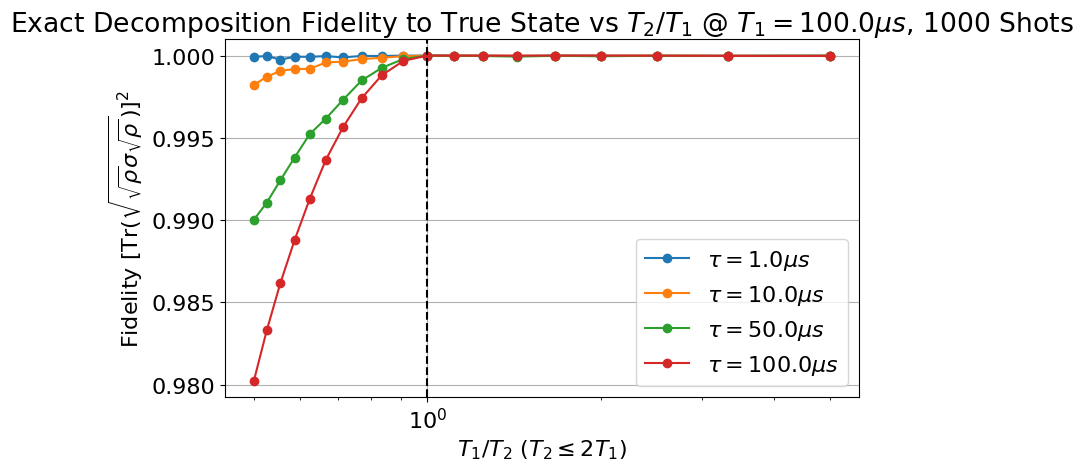

In [39]:
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

# def clean_density_matrix(rho, eps=1e-12):
#     """Stabilize a nearly-valid density matrix."""
#     rho = (rho + rho.conj().T) / 2  # Enforce Hermitian
#     eigvals, eigvecs = np.linalg.eigh(rho)
#     eigvals = np.clip(eigvals, eps, None)  # Avoid zero or negative eigenvalues
#     rho = eigvecs @ np.diag(eigvals) @ eigvecs.conj().T
#     return rho / np.trace(rho)

# def stable_sqrtm(mat):
#     """Stable square root of a matrix, forcing Hermitian output."""
#     sqrt = sqrtm(mat)
#     if np.any(np.isnan(sqrt)) or np.any(np.isinf(sqrt)):
#         raise ValueError("sqrtm failed: produced NaNs or infs.")
#     return (sqrt + sqrt.conj().T) / 2  # Hermitian

def fidelity(rho, sigma):
    sqrt_rho = sqrtm(rho)
    inner = sqrtm(sqrt_rho @ sigma @ sqrt_rho)
    fid = (np.trace(inner)) ** 2
    return fid

# Assuming true_dms and approx_dms are already defined
# print(density_matrices)
# print(exact_rho)

tau_fidelities = []

# f = fidelity(exact_rho[.001], density_matrices[.001])
# print(f)
for i in range(len(taus)):
    fidelities = []
    for j in range(len(T2)):
        rho = np.real(exact_params[i][j])
        sigma = np.real(stab_params[i][j])
        f = fidelity(rho, sigma)
        fidelities.append(f)
    tau_fidelities.append(fidelities)

# print(exact_rho)
# print(density_matrices)
# print(tau_fidelities[0])

# Plot
plt.figure(figsize=(8, 5))

for i, fidelities in enumerate(tau_fidelities):
    plt.plot(T1/np.array(T2) , fidelities, marker='o', label=fr'$\tau = {round(10**6*taus[i], 2)}\mu s$')

plt.plot()

plt.axvline(x=1, color='black', linestyle='--')
plt.xscale('log')

plt.xlabel(r'$T_1/T_2$ ($T_2 \leq 2T_1$)')
plt.ylabel(r'Fidelity $[\mathrm{Tr}(\sqrt{\sqrt{\rho}\sigma\sqrt{\rho}})]^2$')
plt.title(rf'Exact Decomposition Fidelity to True State vs $T_2/T_1$ @ $T_1 ={10**6*T1}\mu s$, 1000 Shots')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
#check diamond norm

**Quasiprobability Graph Un-normalized**

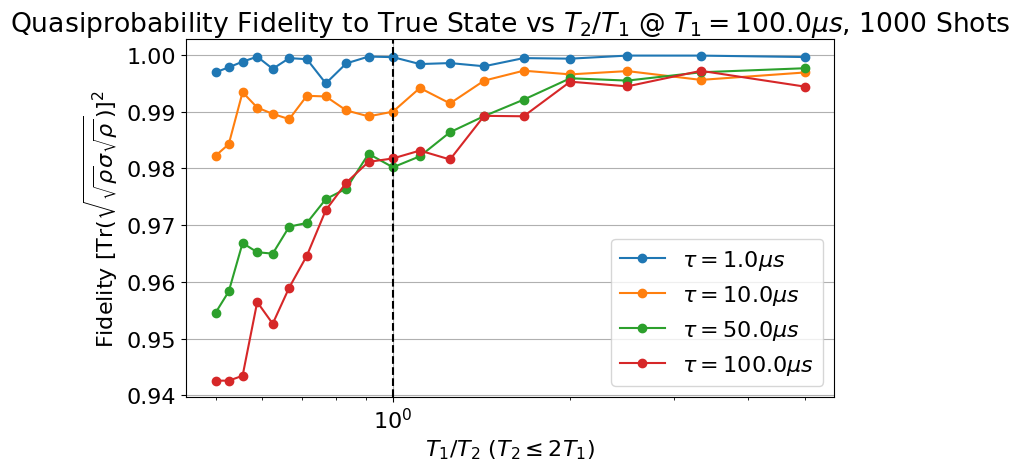

In [40]:
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

# def clean_density_matrix(rho, eps=1e-12):
#     """Stabilize a nearly-valid density matrix."""
#     rho = (rho + rho.conj().T) / 2  # Enforce Hermitian
#     eigvals, eigvecs = np.linalg.eigh(rho)
#     eigvals = np.clip(eigvals, eps, None)  # Avoid zero or negative eigenvalues
#     rho = eigvecs @ np.diag(eigvals) @ eigvecs.conj().T
#     return rho / np.trace(rho)

# def stable_sqrtm(mat):
#     """Stable square root of a matrix, forcing Hermitian output."""
#     sqrt = sqrtm(mat)
#     if np.any(np.isnan(sqrt)) or np.any(np.isinf(sqrt)):
#         raise ValueError("sqrtm failed: produced NaNs or infs.")
#     return (sqrt + sqrt.conj().T) / 2  # Hermitian

def fidelity(rho, sigma):
    sqrt_rho = sqrtm(rho)
    inner = sqrtm(sqrt_rho @ sigma @ sqrt_rho)
    fid = (np.trace(inner)) ** 2
    return fid

# Assuming true_dms and approx_dms are already defined
# print(density_matrices)
# print(exact_rho)

tau_fidelities = []

# f = fidelity(exact_rho[.001], density_matrices[.001])
# print(f)
for i in range(len(taus)):
    fidelities = []
    for j in range(len(T2)):
        rho = np.real(exact_params[i][j])
        sigma = np.real(quasi_params[i][j])
        f = fidelity(rho, sigma)
        fidelities.append(f)
    tau_fidelities.append(fidelities)

# print(exact_rho)
# print(density_matrices)
# print(tau_fidelities[0])

# Plot
plt.figure(figsize=(8, 5))

for i, fidelities in enumerate(tau_fidelities):
    plt.plot(T1/np.array(T2) , fidelities, marker='o', label=fr'$\tau = {round(10**6*taus[i], 2)}\mu s$')

plt.plot()

plt.axvline(x=1, color='black', linestyle='--')
plt.xscale('log')

plt.xlabel(r'$T_1/T_2$ ($T_2 \leq 2T_1$)')
plt.ylabel(r'Fidelity $[\mathrm{Tr}(\sqrt{\sqrt{\rho}\sigma\sqrt{\rho}})]^2$')
plt.title(rf'Quasiprobability Fidelity to True State vs $T_2/T_1$ @ $T_1 ={10**6*T1}\mu s$, 1000 Shots')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
#check diamond norm

**Quasiprobability Graph Normalized w/ C1 = 0 Normalized**

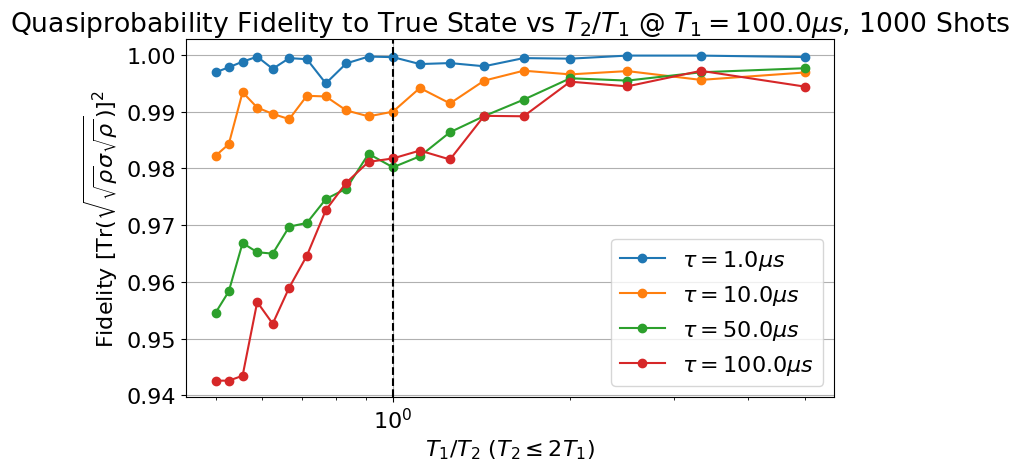

In [41]:
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

# def clean_density_matrix(rho, eps=1e-12):
#     """Stabilize a nearly-valid density matrix."""
#     rho = (rho + rho.conj().T) / 2  # Enforce Hermitian
#     eigvals, eigvecs = np.linalg.eigh(rho)
#     eigvals = np.clip(eigvals, eps, None)  # Avoid zero or negative eigenvalues
#     rho = eigvecs @ np.diag(eigvals) @ eigvecs.conj().T
#     return rho / np.trace(rho)

# def stable_sqrtm(mat):
#     """Stable square root of a matrix, forcing Hermitian output."""
#     sqrt = sqrtm(mat)
#     if np.any(np.isnan(sqrt)) or np.any(np.isinf(sqrt)):
#         raise ValueError("sqrtm failed: produced NaNs or infs.")
#     return (sqrt + sqrt.conj().T) / 2  # Hermitian

def fidelity(rho, sigma):
    sqrt_rho = sqrtm(rho)
    inner = sqrtm(sqrt_rho @ sigma @ sqrt_rho)
    fid = (np.trace(inner)) ** 2
    return fid

# Assuming true_dms and approx_dms are already defined
# print(density_matrices)
# print(exact_rho)

tau_fidelities = []

# f = fidelity(exact_rho[.001], density_matrices[.001])
# print(f)
for i in range(len(taus)):
    fidelities = []
    for j in range(len(T2)):
        rho = np.real(exact_params[i][j])
        sigma = np.real(quasi_params[i][j])
        f = fidelity(rho, sigma)
        fidelities.append(f)
    tau_fidelities.append(fidelities)

# print(exact_rho)
# print(density_matrices)
# print(tau_fidelities[0])

# Plot
plt.figure(figsize=(8, 5))

for i, fidelities in enumerate(tau_fidelities):
    plt.plot(T1/np.array(T2) , fidelities, marker='o', label=fr'$\tau = {round(10**6*taus[i], 2)}\mu s$')

plt.plot()

plt.axvline(x=1, color='black', linestyle='--')
plt.xscale('log')

plt.xlabel(r'$T_1/T_2$ ($T_2 \leq 2T_1$)')
plt.ylabel(r'Fidelity $[\mathrm{Tr}(\sqrt{\sqrt{\rho}\sigma\sqrt{\rho}})]^2$')
plt.title(rf'Quasiprobability Fidelity to True State vs $T_2/T_1$ @ $T_1 ={10**6*T1}\mu s$, 1000 Shots')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
#check diamond norm

**Quasiprobability Graph Normalized w/ C1 = |C1| (Unbiased)**

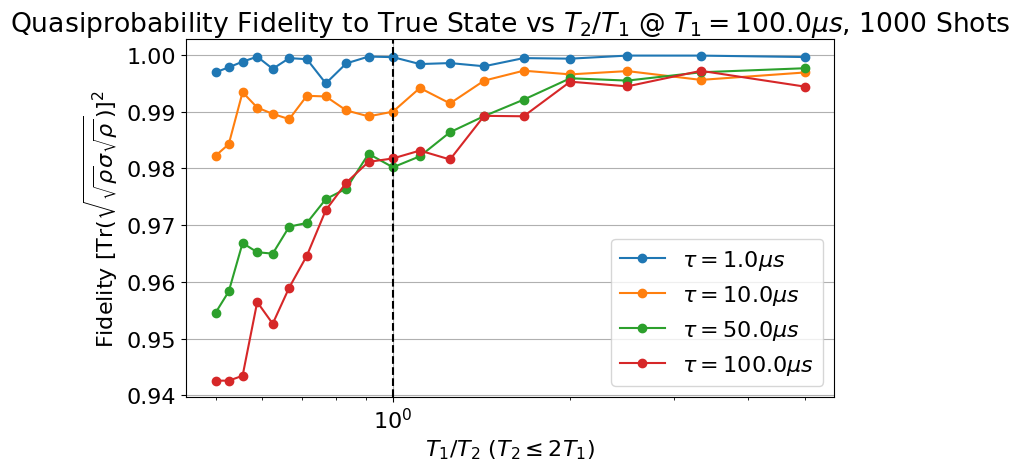

In [42]:
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

# def clean_density_matrix(rho, eps=1e-12):
#     """Stabilize a nearly-valid density matrix."""
#     rho = (rho + rho.conj().T) / 2  # Enforce Hermitian
#     eigvals, eigvecs = np.linalg.eigh(rho)
#     eigvals = np.clip(eigvals, eps, None)  # Avoid zero or negative eigenvalues
#     rho = eigvecs @ np.diag(eigvals) @ eigvecs.conj().T
#     return rho / np.trace(rho)

# def stable_sqrtm(mat):
#     """Stable square root of a matrix, forcing Hermitian output."""
#     sqrt = sqrtm(mat)
#     if np.any(np.isnan(sqrt)) or np.any(np.isinf(sqrt)):
#         raise ValueError("sqrtm failed: produced NaNs or infs.")
#     return (sqrt + sqrt.conj().T) / 2  # Hermitian

def fidelity(rho, sigma):
    sqrt_rho = sqrtm(rho)
    inner = sqrtm(sqrt_rho @ sigma @ sqrt_rho)
    fid = (np.trace(inner)) ** 2
    return fid

# Assuming true_dms and approx_dms are already defined
# print(density_matrices)
# print(exact_rho)

tau_fidelities = []

# f = fidelity(exact_rho[.001], density_matrices[.001])
# print(f)
for i in range(len(taus)):
    fidelities = []
    for j in range(len(T2)):
        rho = np.real(exact_params[i][j])
        sigma = np.real(quasi_params[i][j])
        f = fidelity(rho, sigma)
        fidelities.append(f)
    tau_fidelities.append(fidelities)

# print(exact_rho)
# print(density_matrices)
# print(tau_fidelities[0])

# Plot
plt.figure(figsize=(8, 5))

for i, fidelities in enumerate(tau_fidelities):
    plt.plot((T1/np.array(T2)), fidelities, marker='o', label=fr'$\tau = {round(10**6*taus[i], 2)}\mu s$')

plt.plot()

plt.axvline(x=1, color='black', linestyle='--')
plt.xscale('log')

plt.xlabel(r'$T_1/T_2$ ($T_2 \leq 2T_1$)')
plt.ylabel(r'Fidelity $[\mathrm{Tr}(\sqrt{\sqrt{\rho}\sigma\sqrt{\rho}})]^2$')
plt.title(rf'Quasiprobability Fidelity to True State vs $T_2/T_1$ @ $T_1 ={10**6*T1}\mu s$, 1000 Shots')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
#check diamond norm

**Stim Pauli Twirling Decomposition Graph**

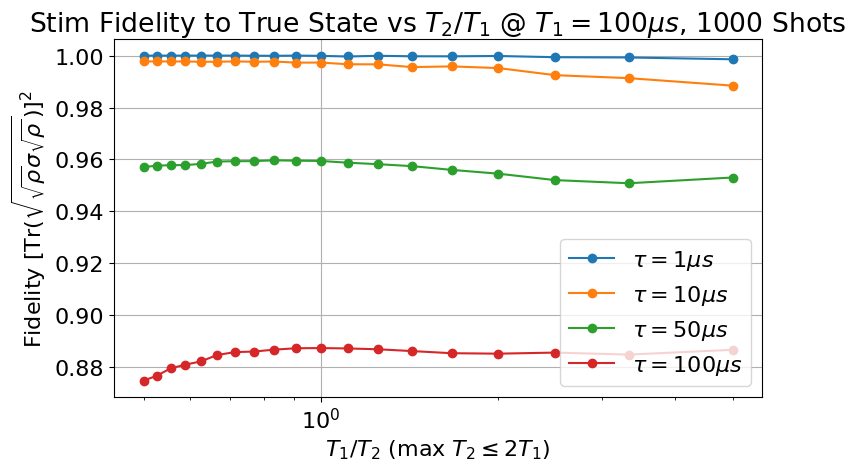

In [43]:
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

# def clean_density_matrix(rho, eps=1e-12):
#     """Stabilize a nearly-valid density matrix."""
#     rho = (rho + rho.conj().T) / 2  # Enforce Hermitian
#     eigvals, eigvecs = np.linalg.eigh(rho)
#     eigvals = np.clip(eigvals, eps, None)  # Avoid zero or negative eigenvalues
#     rho = eigvecs @ np.diag(eigvals) @ eigvecs.conj().T
#     return rho / np.trace(rho)

# def stable_sqrtm(mat):
#     """Stable square root of a matrix, forcing Hermitian output."""
#     sqrt = sqrtm(mat)
#     if np.any(np.isnan(sqrt)) or np.any(np.isinf(sqrt)):
#         raise ValueError("sqrtm failed: produced NaNs or infs.")
#     return (sqrt + sqrt.conj().T) / 2  # Hermitian

def fidelity(rho, sigma):
    sqrt_rho = sqrtm(rho)
    inner = sqrtm(sqrt_rho @ sigma @ sqrt_rho)
    fid = (np.trace(inner)) ** 2
    return fid

# Assuming true_dms and approx_dms are already defined
# print(density_matrices)
# print(exact_rho)

tau_fidelities = []

# f = fidelity(exact_rho[.001], density_matrices[.001])
# print(f)
for i in range(len(taus)):
    fidelities = []
    for j, T in enumerate(T2):
        rho = np.real(exact_params[i][j])
        sigma = np.real(stim_params[i][j])
        f = fidelity(rho, sigma)
        fidelities.append(f)
    tau_fidelities.append(fidelities)

# print(exact_rho)
# print(density_matrices)
# print(tau_fidelities[0])

# Plot
plt.figure(figsize=(8, 5))
plt.xscale('log')

for i, fidelities in enumerate(tau_fidelities):
    plt.plot(T1/np.array(T2), fidelities, marker='o', label=fr'$\tau = {int(round(10**6*taus[i]))}\mu s$')

plt.xlabel(r'$T_1/T_2$ (max $T_2 \leq 2T_1$)')
plt.ylabel(r'Fidelity $[\mathrm{Tr}(\sqrt{\sqrt{\rho}\sigma\sqrt{\rho}})]^2$')
plt.title(rf'Stim Fidelity to True State vs $T_2/T_1$ @ $T_1 = {int(10**6*T1)}\mu s$, 1000 Shots')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Detailed Fidelity for PR**

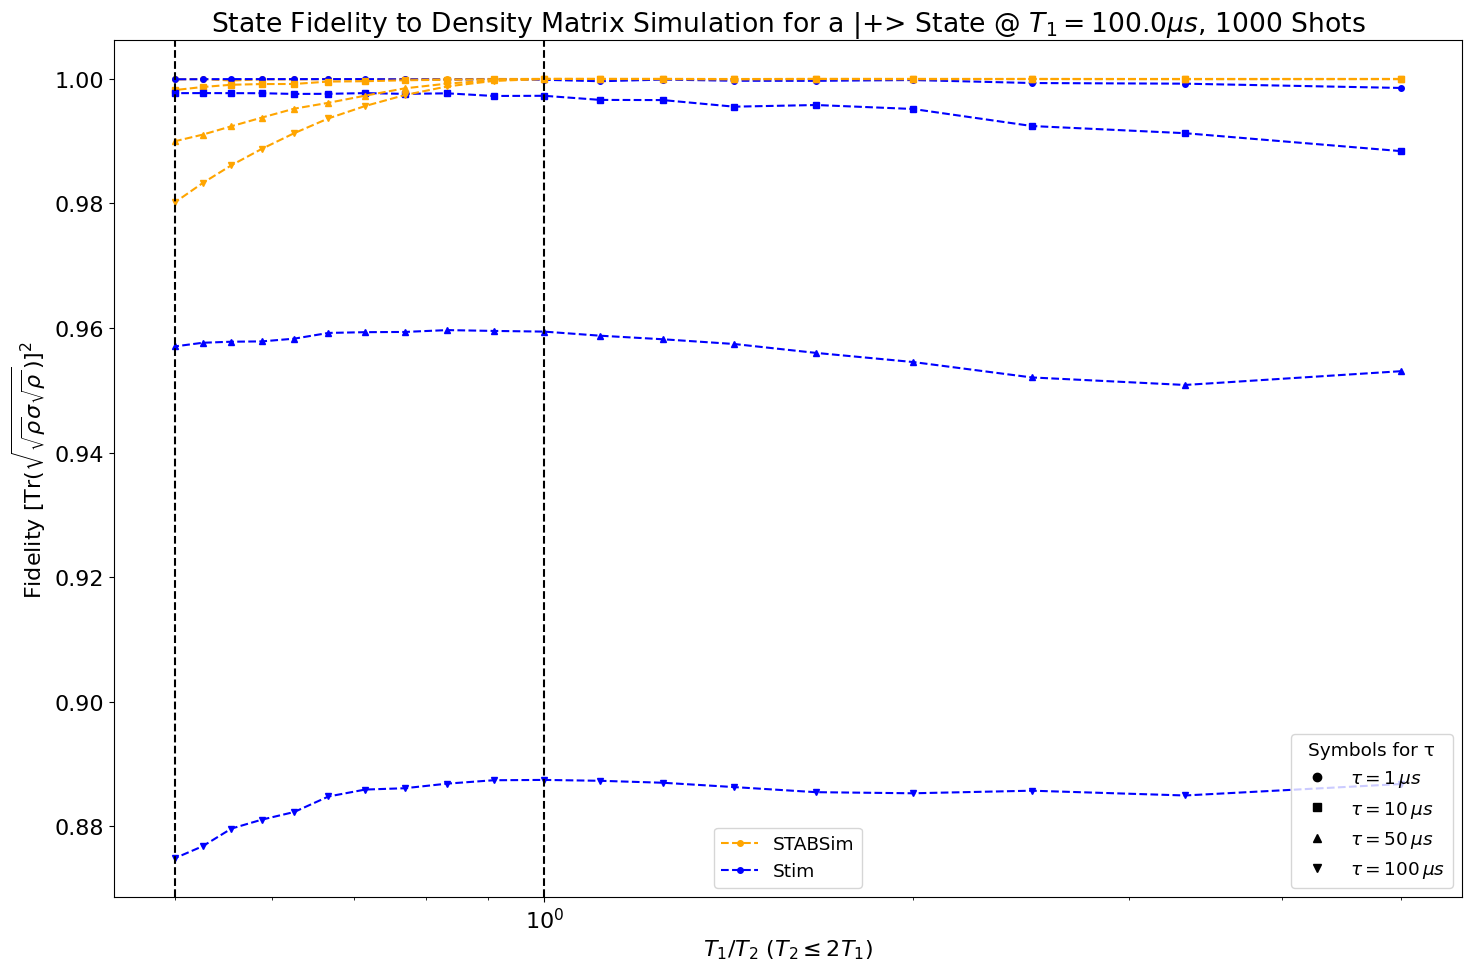

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import sqrtm
from matplotlib.lines import Line2D

def fidelity(rho, sigma):
    sqrt_rho = sqrtm(rho)
    inner = sqrtm(sqrt_rho @ sigma @ sqrt_rho)
    fid = (np.trace(inner)) ** 2
    return np.real(fid)

# Example dummy data setup
# taus, T1, T2, exact_params, stim_params, stab_params must be defined before this point
# For illustration:
# taus = [1, 2, 3]
# T1 = 1
# T2 = np.array([1, 2, 3])
# exact_params = stim_params = stab_params = [[[np.eye(2)]*3]*3]  # Dummy structure

markers = ['o', 's', '^', 'v', 'D', 'x', '*', 'P', 'H', '<', '>']
markers = (markers * ((len(taus) // len(markers)) + 1))[:len(taus)]

colors = ['blue', 'orange']  # Group 1 (exact), Group 2 (stab)

plt.figure(figsize=(15, 10))
ax = plt.gca()

for i, tau in enumerate(taus):
    fidelities_stab = [
        fidelity(np.real(exact_params[i][j]), np.real(stab_params[i][j]))
        for j in range(len(T2))
    ]
    ax.plot(
        T1 / np.array(T2),
        fidelities_stab,
        color=colors[1],
        marker=markers[i],
        markersize=4,
        linewidth=1.5,
        linestyle='--',
        label='STABSim' if i == 0 else None  # Avoid repeating in legend
    )

    fidelities_stim = [
        fidelity(np.real(exact_params[i][j]), np.real(stim_params[i][j]))
        for j in range(len(T2))
    ]
    ax.plot(
        T1 / np.array(T2),
        fidelities_stim,
        color=colors[0],
        marker=markers[i],
        markersize=4,
        linewidth=1.5,
        linestyle='--',
        label='Stim' if i == 0 else None
    )

# Vertical reference lines
ax.axvline(x=1, color='black', linestyle='--')
ax.axvline(x=0.5, color='black', linestyle='--')



ax.set_xlabel(r'$T_1/T_2$ ($T_2 \leq 2T_1$)')
ax.set_ylabel(r'Fidelity $[\mathrm{Tr}(\sqrt{\sqrt{\rho}\sigma\sqrt{\rho}})]^2$')
ax.set_title(rf'State Fidelity to Density Matrix Simulation for a |+> State @ $T_1 ={10**6*T1}\mu s$, 1000 Shots')

# Legend for Stim / STABSim
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend1 = ax.legend(by_label.values(), by_label.keys(), loc='lower center', fontsize='small')
ax.add_artist(legend1)

# Legend for tau markers
tau_marker_handles = [
    Line2D([0], [0], marker=markers[i], color='black', linestyle='None', label=fr'$\tau = {taus[i] * 1e6:.0f}\,\mu s$')
    for i in range(len(taus))
]
legend2 = ax.legend(
    tau_marker_handles,
    [fr"$\tau = {taus[i] * 1e6:.0f}\,\mu s$" for i in range(len(taus))],
    title="Symbols for τ",
    loc='lower right',
    fontsize='small',
    title_fontsize='small'
)
plt.xscale('log')
plt.tight_layout()
plt.show()


**Simplified Fidelity+Speed for ASPLOS**

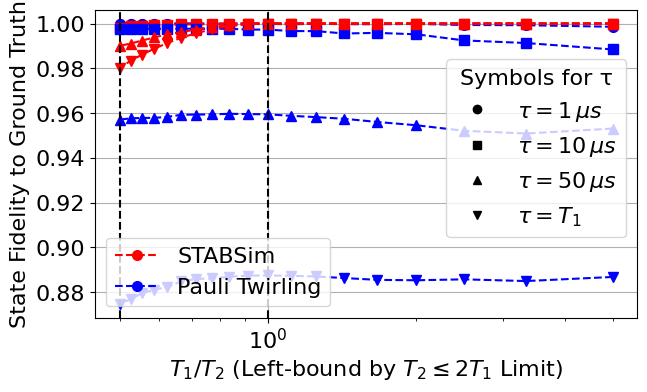

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import sqrtm
from matplotlib.lines import Line2D

def fidelity(rho, sigma):
    sqrt_rho = sqrtm(rho)
    inner = sqrtm(sqrt_rho @ sigma @ sqrt_rho)
    fid = (np.trace(inner)) ** 2
    return np.real(fid)

# Example dummy data setup
# taus, T1, T2, exact_params, stim_params, stab_params must be defined before this point
# For illustration:
# taus = [1, 2, 3]
# T1 = 1
# T2 = np.array([1, 2, 3])
# exact_params = stim_params = stab_params = [[[np.eye(2)]*3]*3]  # Dummy structure

markers = ['o', 's', '^', 'v', 'D', 'x', '*', 'P', 'H', '<', '>']
markers = (markers * ((len(taus) // len(markers)) + 1))[:len(taus)]

colors = ['blue', 'red']  # Group 1 (exact), Group 2 (stab)

plt.figure(figsize=(7, 4))
ax = plt.gca()

for i, tau in enumerate(taus):
    fidelities_stab = [
        fidelity(np.real(exact_params[i][j]), np.real(stab_params[i][j]))
        for j in range(len(T2))
    ]
    ax.plot(
        T1 / np.array(T2),
        fidelities_stab,
        color=colors[1],
        marker=markers[i],
        markersize=7,
        linewidth=1.5,
        linestyle='--',
        label='STABSim' if i == 0 else None  # Avoid repeating in legend
    )

    fidelities_stim = [
        fidelity(np.real(exact_params[i][j]), np.real(stim_params[i][j]))
        for j in range(len(T2))
    ]
    ax.plot(
        T1 / np.array(T2),
        fidelities_stim,
        color=colors[0],
        marker=markers[i],
        markersize=7,
        linewidth=1.5,
        linestyle='--',
        label='Pauli Twirling' if i == 0 else None
    )

# Vertical reference lines
ax.axvline(x=1, color='black', linestyle='--')
ax.axvline(x=0.5, color='black', linestyle='--')

ax.set_xlabel(r'$T_1/T_2$ (Left-bound by $T_2 \leq 2T_1$ Limit)')
ax.set_ylabel(r'State Fidelity to Ground Truth')
# ax.set_title(r'T1 & T2 Damping @ $T_1 = 100\mu s$, 100 Shots')

# Legend for Stim / STABSim
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend1 = ax.legend(by_label.values(), by_label.keys(), loc='lower left')
ax.add_artist(legend1)

# Legend for tau markers
tau_marker_handles = [
    Line2D([0], [0], marker=markers[i], color='black', linestyle='None', label=fr'$\tau = {taus[i] * 1e6:.0f}\,\mu s$')
    for i in range(len(taus))
]
legend2 = ax.legend(
    tau_marker_handles,
    [
        r"$\tau = T_1$" if i == len(taus) - 1 else fr"$\tau = {taus[i] * 1e6:.0f}\,\mu s$"
        for i in range(len(taus))
    ],
    title="Symbols for τ",
    loc='center right',
    bbox_to_anchor=(1, .55)
)
ax.set_xscale('log')
ax.grid(True)
plt.rcParams.update({'font.size': 14})

plt.savefig('fidelity_plot.pdf', dpi=1000, bbox_inches='tight')



**Trace Distance**

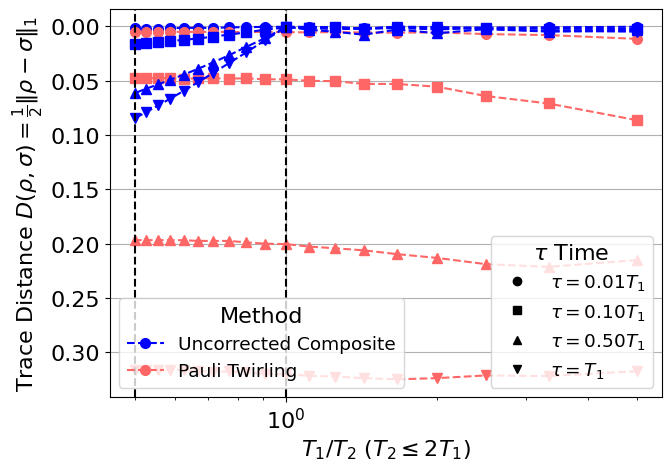

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.colors as mcolors


def trace_distance(rho, sigma):
    delta = rho - sigma
    eigvals = np.linalg.eigvalsh(delta @ delta.conj().T)
    return 0.5 * np.sum(np.sqrt(np.maximum(eigvals, 0)))  # ensure non-negative due to numerical error

# Example marker cycle (one per tau)
markers = ['o', 's', '^', 'v', 'D', 'x', '*', 'P', 'H', '<', '>']
markers = (markers * ((len(taus) // len(markers)) + 1))[:len(taus)]
colors = ['blue', 'red']  # Group 1 (exact), Group 2 (stab)

plt.figure(figsize=(7, 5))

tau_handles = []  # to store one marker per tau

cmap = plt.get_cmap('tab10')
def lighten(color, factor=0.6):
    c = np.array(mcolors.to_rgb(color))
    return tuple(1 - (1 - c) * factor)

def darken(color, factor=0.8):
    c = np.array(mcolors.to_rgb(color))
    return tuple(c * factor)


base = cmap(cmap.N)
stim_color = lighten(base, 0.6)
cpp_color  = darken(base, 0.8)

def tau_label(tau, T1):
    """Return tau label always as a multiple of T1."""
    ratio = tau / T1
    if np.isclose(ratio, 1.0):
        return r'$\tau = T_1$'
    elif ratio < 1:
        return rf'$\tau = {ratio:.2f} T_1$'
    else:
        return rf'$\tau = {ratio:.2f} T_1$'

for i, tau in enumerate(taus):
    # Group 1: exact vs stab
    distances_stab = [
        trace_distance(np.real(exact_params[i][j]), np.real(stab_params[i][j]))
        for j in range(len(T2))
    ]
    plt.plot(
        T1 / np.array(T2),
        distances_stab,
        color=colors[0],
        marker=markers[i],
        markersize=7,
        linewidth=1.5,
        linestyle='--',
        label='Uncorrected Composite' if i == 0 else None
    )

    # Group 2: exact vs stim
    distances_stim = [
        trace_distance(np.real(exact_params[i][j]), np.real(stim_params[i][j]))
        for j in range(len(T2))
    ]
    plt.plot(
        T1 / np.array(T2),
        distances_stim,
        color=lighten(colors[1]),
        marker=markers[i],
        markersize=7,
        linewidth=1.5,
        linestyle='--',
        label='Pauli Twirling' if i == 0 else None
    )

    # Tau legend entry
    tau_handle, = plt.plot([], [], marker=markers[i], color='black', linestyle='None',
                           label=tau_label(tau, T1))
    tau_handles.append(tau_handle)

# Vertical reference lines
plt.axvline(x=1, color='black', linestyle='--')
plt.axvline(x=.5, color='black', linestyle='--')

plt.xlabel(r'$T_1/T_2$ ($T_2 \leq 2T_1$)')
plt.ylabel(r'Trace Distance $D(\rho, \sigma) = \frac{1}{2}\|\rho - \sigma\|_1$')
plt.gca().invert_yaxis()

# Legend for simulation methods
method_handles, method_labels = plt.gca().get_legend_handles_labels()
method_legend = plt.legend(method_handles[:2], method_labels[:2],
                           loc='lower left', fontsize='small', title="Method")

# Legend for tau values (as multiples of T1)
tau_legend = plt.legend(handles=tau_handles, loc='lower right', fontsize='small', title=r'$\tau$ Time')

plt.gca().add_artist(method_legend)
plt.rcParams.update({'font.size': 16})


plt.xscale('log')
plt.grid(True)
plt.tight_layout()

plt.savefig('trace_distance.pdf', dpi=1000, bbox_inches='tight')

plt.show()


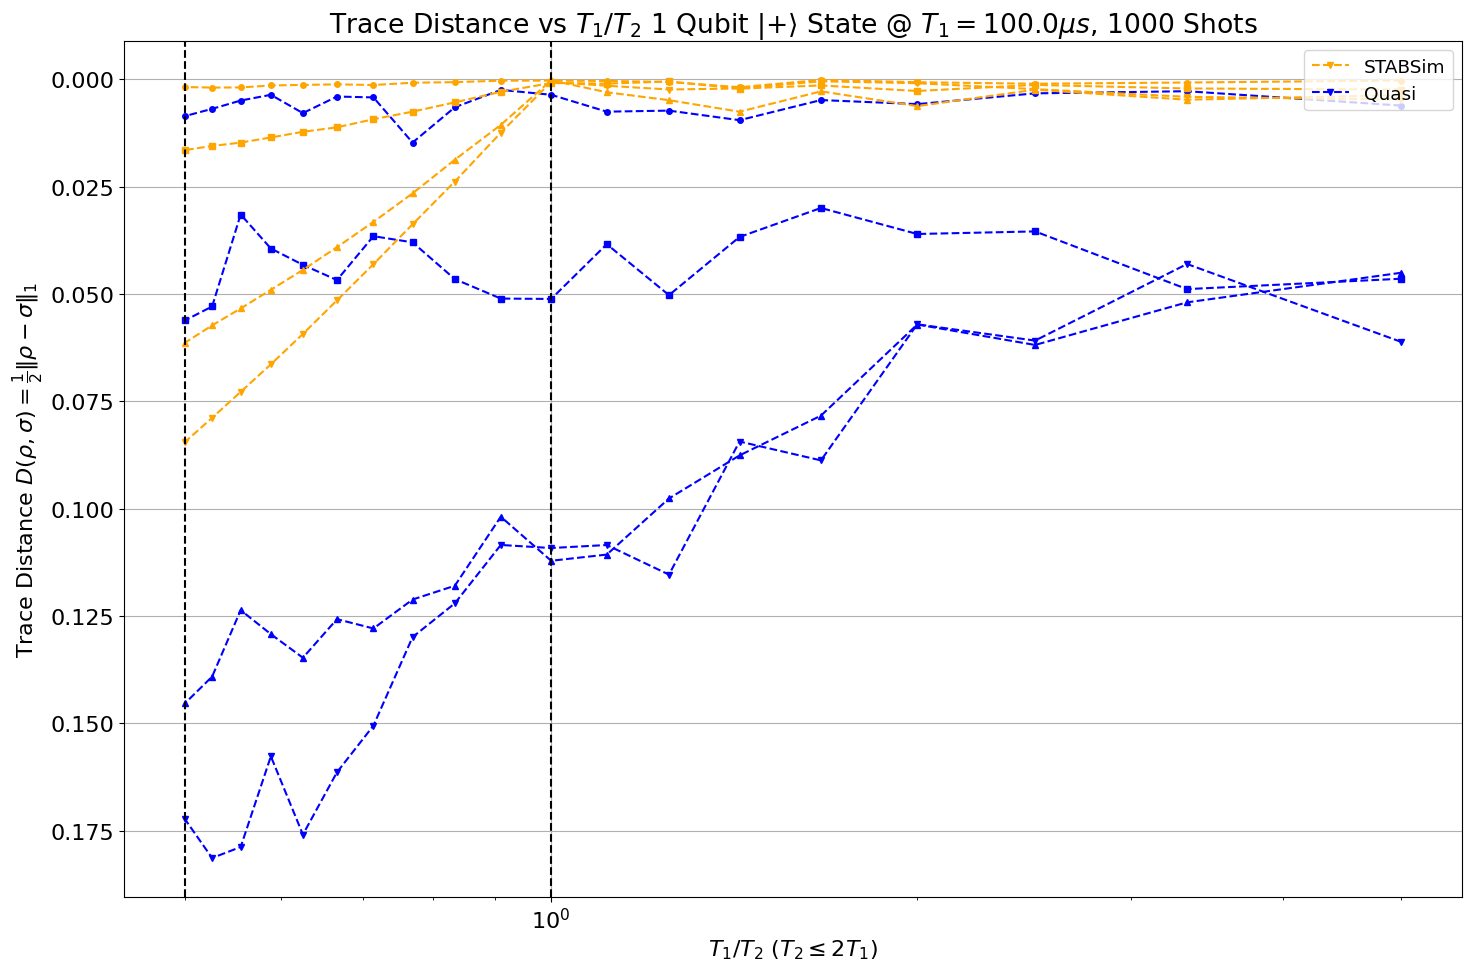

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import sqrtm

def trace_distance(rho, sigma):
    delta = rho - sigma
    eigvals = np.linalg.eigvalsh(delta @ delta.conj().T)
    return 0.5 * np.sum(np.sqrt(np.maximum(eigvals, 0)))  # ensure non-negative due to numerical error

# Example marker cycle (one per tau)
markers = ['o', 's', '^', 'v', 'D', 'x', '*', 'P', 'H', '<', '>']
markers = (markers * ((len(taus) // len(markers)) + 1))[:len(taus)]
colors = ['blue', 'orange']  # Group 1 (exact), Group 2 (stab)

plt.figure(figsize=(15, 10))

for i, tau in enumerate(taus):
    # Group 1: trace distance between exact and stab
    distances_stab = [
        trace_distance(np.real(exact_params[i][j]), np.real(stab_params[i][j]))
        for j in range(len(T2))
    ]
    plt.plot(
        T1 / np.array(T2),
        distances_stab,
        color=colors[1],
        marker=markers[i],
        markersize=4,
        linewidth=1.5,
        linestyle='--',
        label='STABSim'
    )

    # Group 2: trace distance between exact and stim
    distances_stim = [
        trace_distance(np.real(exact_params[i][j]), np.real(quasi_params[i][j]))
        for j in range(len(T2))
    ]
    plt.plot(
        T1 / np.array(T2),
        distances_stim,
        color=colors[0],
        marker=markers[i],
        markersize=4,
        linewidth=1.5,
        linestyle='--',
        label='Quasi'
    )

plt.axvline(x=1, color='black', linestyle='--')
plt.axvline(x=.5, color='black', linestyle='--')
plt.xlabel(r'$T_1/T_2$ ($T_2 \leq 2T_1$)')
plt.ylabel(r'Trace Distance $D(\rho, \sigma) = \frac{1}{2}\|\rho - \sigma\|_1$')
plt.gca().invert_yaxis()

plt.title(rf'Trace Distance vs $T_1/T_2$ 1 Qubit |+⟩ State @ $T_1 ={10**6*T1}\mu s$, 1000 Shots')

# Only label the two groups once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize='small')

plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()